In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
my_df = pd.read_csv('drive/MyDrive/datasets/input_data_after_preprocessing_for_ml.csv')
#my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,Unnamed: 0,Combined Description Cleaned,Assignment group
0,0,login issue user manager name checked the name...,GRP_0
1,1,outlook received from hello team my are not in...,GRP_0
2,2,cannot log in to received from hi i cannot on ...,GRP_0
3,3,unable to access tool page,GRP_0
4,4,error,GRP_0


In [4]:
df2 = my_df
my_df['Assignment group by number'] = my_df['Assignment group'].str[4:]
my_df['Assignment group by number'] = my_df['Assignment group by number'].astype(int)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    8500 non-null   int64 
 1   Combined Description Cleaned  8500 non-null   object
 2   Assignment group              8500 non-null   object
 3   Assignment group by number    8500 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 265.8+ KB


In [5]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    8500 non-null   int64 
 1   Combined Description Cleaned  8500 non-null   object
 2   Assignment group              8500 non-null   object
 3   Assignment group by number    8500 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 265.8+ KB


In [6]:
x = my_df['Combined Description Cleaned']
y = my_df['Assignment group by number']

In [7]:
y = tf.keras.utils.to_categorical(y)

In [8]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.20,
                                                                                  random_state=SEED, shuffle=True)
                                                                                 # stratify=y)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [9]:
y_train.shape

(6800, 74)

In [10]:
y_validation.shape

(850, 74)

In [11]:
from sklearn.linear_model import LogisticRegression

## Doc2Vec

Before we jump into doc2vec, it will be better to first start by word2vec. "Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words."

DM: 
This is the Doc2Vec model analogous to CBOW model in Word2vec. The paragraph vectors are obtained by training a neural network on the task of inferring a centre word based on context words and a context paragraph. 

DBOW:
This is the Doc2Vec model analogous to Skip-gram model in Word2Vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Below are the methods I used to get the vectors for each ticket.

1. DBOW (Distributed Bag of Words)
2. DMC (Distributed Memory Concatenated)
3. DMM (Distributed Memory Mean)
4. DBOW + DMC
5. DBOW + DMM

With above vectors, I fit a simple logistic regression model and evaluated the result on the validation set.

In [12]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

In [13]:
def labelize_tickets_ug(tickets,label):
    result = []
    prefix = label
    for i, t in zip(tickets.index, tickets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result

Also, the same rationale has been applied in the Gensim's Doc2Vec tutorial. In the IMDB tutorial, vector training is occurring on all documents of the data set, including all train/test/dev set. https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb

In [14]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tickets_ug(all_x, 'all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [15]:
len(all_x_w2v)

8500

In [16]:
all_x_w2v

[LabeledSentence(words=['evening', 'job', 'in', 'schedule', 'job', 'received', 'from', 'job', 'schedule', 'job', 'at'], tags=['all_7628']),
 LabeledSentence(words=['unable', 'to', 'display', 'expense', 'report'], tags=['all_123']),
 LabeledSentence(words=['job', 'hot', 'in', 'job', 'schedule', 'at', 'received', 'from'], tags=['all_6569']),
 LabeledSentence(words=['speaker', 'not', 'working', 'in', 'received', 'from', 'hello', 'i', 'am', 'facing', 'the', 'issue', 'of', 'no', 'sound', 'during', 'meeting', 'kindly', 'do', 'needful', 'best'], tags=['all_552']),
 LabeledSentence(words=['unable', 'to', 'login'], tags=['all_6711']),
 LabeledSentence(words=['down', 'especially', 'scan', 'to', 'is', 'not', 'working', 'server', 'no', 'reply', 'ping', 'error', 'communication', 'error', 'contact', 'name', 'known', 'location'], tags=['all_7272']),
 LabeledSentence(words=['network', 'multiple', 'are', 'running', 'slow', 'how', 'did', 'you', 'determine', 'there', 'error', 'web', 'page', 'not', 'in', 

## DBOW

In [17]:
model_ug_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 1768607.20it/s]


According to the developer Radim Řehůřek who created Gensim,
"One caveat of the way this algorithm runs is that, since the learning rate decrease over the course of iterating over the data, labels which are only seen in a single LabeledSentence during training will only be trained with a fixed learning rate. This frequently produces less than optimal results."

Below iteration implement explicit multiple-pass, alpha-reduction approach with added shuffling. This has been already presented in Gensim's IMDB tutorial.

In [18]:
%%time
for epoch in range(30):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha

100%|██████████| 8500/8500 [00:00<00:00, 3002491.49it/s]


CPU times: user 17.5 s, sys: 3.45 s, total: 21 s
Wall time: 13.8 s


In [19]:
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

In [20]:
train_vecs_dbow = get_vectors(model_ug_dbow, x_train, 100)
validation_vecs_dbow = get_vectors(model_ug_dbow, x_validation, 100)

In [21]:
model_ug_dbow.save('drive/MyDrive/grams/d2v_model_ug_dbow.doc2vec')
model_ug_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dbow.doc2vec')

In [22]:
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## Distributed Memory (concatenated)

In [23]:
cores = multiprocessing.cpu_count()
model_ug_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmc.build_vocab([x for x in tqdm(all_x_w2v)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 2346734.07it/s]


In [24]:
%%time
for epoch in range(30):
    model_ug_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmc.alpha -= 0.002
    model_ug_dmc.min_alpha = model_ug_dmc.alpha

100%|██████████| 8500/8500 [00:00<00:00, 3356706.90it/s]


CPU times: user 26.2 s, sys: 4.15 s, total: 30.4 s
Wall time: 16.9 s


In [25]:
#model_ug_dmc = Doc2Vec.load('d2v_model_ug_dmc.doc2vec')


What's nice about Doc2Vec is that after training you can retrieve not only document vectors but also individual word vectors as well. Note, however, that a Doc2Vec DBOW model doesn't learn semantic word vectors, so the word vectors you retrieve from pure DBOW model will be the automatic randomly-initialized vectors, with no meaning.
But with DM model, you can see the semantic relationship between words. Let's see what word vectors it has learned through training.

In [26]:
model_ug_dmc.most_similar('good')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('attention', 0.5905939340591431),
 ('nice', 0.511900782585144),
 ('middle', 0.48280268907546997),
 ('vpn', 0.48194408416748047),
 ('junior', 0.47145965695381165),
 ('collect', 0.4606859087944031),
 ('hi', 0.4461682438850403),
 ('substitute', 0.43519267439842224),
 ('disclosure', 0.4207365810871124),
 ('termination', 0.4183597266674042)]

In [27]:
model_ug_dmc.most_similar('network')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('injection', 0.43343985080718994),
 ('dynamic', 0.4125206470489502),
 ('host', 0.4097335934638977),
 ('defect', 0.4063396751880646),
 ('stele', 0.40369319915771484),
 ('chassis', 0.40247029066085815),
 ('synchronization', 0.40232905745506287),
 ('mac', 0.400371253490448),
 ('invoke', 0.398945152759552),
 ('availability', 0.3978036642074585)]

What's interesting with DMC model is, somehow it learned all the misspelled version of a word as you can see from the above.

In [28]:
model_ug_dmc.most_similar('password')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('solely', 0.5100976824760437),
 ('reset', 0.4967358708381653),
 ('unlocked', 0.4905116856098175),
 ('ea', 0.4886753559112549),
 ('fae', 0.48320236802101135),
 ('hex', 0.48304086923599243),
 ('car', 0.4772396981716156),
 ('venue', 0.4701065123081207),
 ('notebook', 0.462944895029068),
 ('\\', 0.46057823300361633)]

In [29]:
model_ug_dmc.most_similar(positive=['bigger', 'small'], negative=['big'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('differently', 0.4480589032173157),
 ('disclaimer', 0.44250595569610596),
 ('rectified', 0.44035276770591736),
 ('arc', 0.4383450448513031),
 ('foreign', 0.40676844120025635),
 ('preserve', 0.3998541831970215),
 ('hot', 0.3996698558330536),
 ('distance', 0.38804540038108826),
 ('busy', 0.38638895750045776),
 ('coffee', 0.38633108139038086)]

The model successfully catches the comparative form of "small", on feeding the word "big" and "bigger". The above line of code is like asking the model to add the vectors associated with the word "bigger" and "small" while subtracting "big" is equal to the top result, "smaller".

In [30]:
train_vecs_dmc = get_vectors(model_ug_dmc, x_train, 100)
validation_vecs_dmc = get_vectors(model_ug_dmc, x_validation, 100)

In [31]:
model_ug_dmc.save('drive/MyDrive/grams/d2v_model_ug_dmc.doc2vec')
model_ug_dmc = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dmc.doc2vec')
model_ug_dmc.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## Distributed Memory (mean)

In [32]:
cores = multiprocessing.cpu_count()
model_ug_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmm.build_vocab([x for x in tqdm(all_x_w2v)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 2337808.79it/s]


In [33]:
%%time
for epoch in range(30):
    model_ug_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmm.alpha -= 0.002
    model_ug_dmm.min_alpha = model_ug_dmm.alpha

100%|██████████| 8500/8500 [00:00<00:00, 3211275.81it/s]


CPU times: user 36.4 s, sys: 10.2 s, total: 46.6 s
Wall time: 30.2 s


In [34]:
model_ug_dmm.most_similar('schedule')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('arc', 0.5548229217529297),
 ('cold', 0.4966188073158264),
 ('job', 0.49337226152420044),
 ('notch', 0.45535367727279663),
 ('village', 0.42568066716194153),
 ('hot', 0.423348069190979),
 ('alert', 0.38580214977264404),
 ('differently', 0.36731481552124023),
 ('bend', 0.3528343439102173),
 ('dear', 0.3481738567352295)]

In [35]:
model_ug_dmc.most_similar('network')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('injection', 0.43343985080718994),
 ('dynamic', 0.4125206470489502),
 ('host', 0.4097335934638977),
 ('defect', 0.4063396751880646),
 ('stele', 0.40369319915771484),
 ('chassis', 0.40247029066085815),
 ('synchronization', 0.40232905745506287),
 ('mac', 0.400371253490448),
 ('invoke', 0.398945152759552),
 ('availability', 0.3978036642074585)]

In [36]:
train_vecs_dmm = get_vectors(model_ug_dmm, x_train, 100)
validation_vecs_dmm = get_vectors(model_ug_dmm, x_validation, 100)

In [37]:
model_ug_dmm.save('drive/MyDrive/grams/d2v_model_ug_dmm.doc2vec')
model_ug_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dmm.doc2vec')
model_ug_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

Since I have the document vectors from four different models, now I can concatenate them in combination to see how it affects the performance. Below I defined a simple function to concatenate document vectors from different models.

In [38]:
def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

In [39]:
train_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow,model_ug_dmc, x_train, 200)
validation_vecs_dbow_dmc = get_concat_vectors(model_ug_dbow,model_ug_dmc, x_validation, 200)

In [40]:
train_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_train, 200)
validation_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_validation, 200)

In case of unigram, concatenating document vectors in different combination boosted the model performance. The best validation accuracy I got from a single model is from DBOW at 73.89%. With concatenated vectors, I get the highest validation accuracy of 75.51% with DBOW+DMM model.

In [41]:
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser

In [42]:
tokenized_train = [t.split() for t in x_train]

In [43]:
%%time
phrases = Phrases(tokenized_train)
bigram = Phraser(phrases)

CPU times: user 538 ms, sys: 0 ns, total: 538 ms
Wall time: 537 ms


In [44]:
sent = [u'the', u'mayor', u'of', u'new', u'york', u'was', u'there']
print(bigram[sent])

['the', 'mayor', 'of', 'new', 'york', 'was', 'there']


In [45]:
x_train

7628    evening job in schedule job received from job ...
123                      unable to display expense report
6569             job hot in job schedule at received from
552     speaker not working in received from hello i a...
6711                                      unable to login
                              ...                        
3762            performance for machine summary load list
4380                     external not with dell in tablet
1590                please give access to all under mu is
4045    received from hi below apprentice is unable to...
4936                             user this message recall
Name: Combined Description Cleaned, Length: 6800, dtype: object

In [46]:
#x_train[10]

In [47]:
#bigram[x_train[10].split()]

In [48]:
def labelize_tickets_bg(tickets,label):
    result = []
    prefix = label
    for i, t in zip(tickets.index, tickets):
        result.append(LabeledSentence(bigram[t.split()], [prefix + '_%s' % i]))
    return result

In [49]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v_bg = labelize_tickets_bg(all_x, 'all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


## DBOW Bigram

In [50]:
cores = multiprocessing.cpu_count()
model_bg_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dbow.build_vocab([x for x in tqdm(all_x_w2v_bg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 1895957.46it/s]


In [51]:
%%time
for epoch in range(30):
    model_bg_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dbow.alpha -= 0.002
    model_bg_dbow.min_alpha = model_bg_dbow.alpha

100%|██████████| 8500/8500 [00:00<00:00, 3266292.62it/s]


CPU times: user 17.9 s, sys: 3.08 s, total: 21 s
Wall time: 13.9 s


In [52]:
train_vecs_dbow_bg = get_vectors(model_bg_dbow, x_train, 100)
validation_vecs_dbow_bg = get_vectors(model_bg_dbow, x_validation, 100)

In [53]:
model_bg_dbow.save('drive/MyDrive/grams/d2v_model_bg_dbow.doc2vec')
model_bg_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_bg_dbow.doc2vec')
model_bg_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

### DMC Bigram

In [54]:
cores = multiprocessing.cpu_count()
model_bg_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dmc.build_vocab([x for x in tqdm(all_x_w2v_bg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 2451965.89it/s]


In [55]:
%%time
for epoch in range(30):
    model_bg_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dmc.alpha -= 0.002
    model_bg_dmc.min_alpha = model_bg_dmc.alpha

100%|██████████| 8500/8500 [00:00<00:00, 3200321.72it/s]


CPU times: user 23 s, sys: 3.23 s, total: 26.2 s
Wall time: 14.9 s


In [56]:
model_bg_dmc.most_similar('schedule')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('hand_way', 0.5873075127601624),
 ('rerun', 0.5553940534591675),
 ('cold', 0.5538903474807739),
 ('e_d', 0.5451216697692871),
 ('evaluate', 0.5135448575019836),
 ('bend', 0.49177584052085876),
 ('view_disclaimer', 0.4897778332233429),
 ('job', 0.4876520037651062),
 ('your_organization', 0.48649200797080994),
 ('alternate_language', 0.4845648407936096)]

In [57]:
train_vecs_dmc_bg = get_vectors(model_bg_dmc, x_train, 100)
validation_vecs_dmc_bg = get_vectors(model_bg_dmc, x_validation, 100)

In [58]:
model_bg_dmc.save('drive/MyDrive/grams/d2v_model_bg_dmc.doc2vec')
model_bg_dmc = Doc2Vec.load('drive/MyDrive/grams/d2v_model_bg_dmc.doc2vec')
model_bg_dmc.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## DMM Bigram

In [59]:
cores = multiprocessing.cpu_count()
model_bg_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_bg_dmm.build_vocab([x for x in tqdm(all_x_w2v_bg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 2061380.98it/s]


In [60]:
%%time
for epoch in range(30):
    model_bg_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v_bg)]), total_examples=len(all_x_w2v_bg), epochs=1)
    model_bg_dmm.alpha -= 0.002
    model_bg_dmm.min_alpha = model_bg_dmm.alpha

100%|██████████| 8500/8500 [00:00<00:00, 3350397.89it/s]


CPU times: user 37.1 s, sys: 10.8 s, total: 47.9 s
Wall time: 31.2 s


In [61]:
train_vecs_dmm_bg = get_vectors(model_bg_dmm, x_train, 100)
validation_vecs_dmm_bg = get_vectors(model_bg_dmm, x_validation, 100)

In [62]:
model_bg_dmm.save('drive/MyDrive/grams/d2v_model_bg_dmm.doc2vec')
model_bg_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_bg_dmm.doc2vec')
model_bg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [63]:
train_vecs_dbow_dmc_bg = get_concat_vectors(model_bg_dbow,model_bg_dmc, x_train, 200)
validation_vecs_dbow_dmc_bg = get_concat_vectors(model_bg_dbow,model_bg_dmc, x_validation, 200)

In [64]:
train_vecs_dbow_dmm_bg = get_concat_vectors(model_bg_dbow,model_bg_dmm, x_train, 200)
validation_vecs_dbow_dmm_bg = get_concat_vectors(model_bg_dbow,model_bg_dmm, x_validation, 200)

## Trigram

In [65]:
%%time
tg_phrases = Phrases(bigram[tokenized_train])
trigram = Phraser(tg_phrases)

CPU times: user 880 ms, sys: 0 ns, total: 880 ms
Wall time: 880 ms


In [66]:
#trigram[bigram[x_train[10].split()]]

## Below Doc2Vec implementation is again same as unigram or bigram.

In [67]:
def labelize_tickets_tg(tickets,label):
    result = []
    prefix = label
    for i, t in zip(tickets.index, tickets):
        result.append(LabeledSentence(trigram[bigram[t.split()]], [prefix + '_%s' % i]))
    return result

In [68]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v_tg = labelize_tickets_tg(all_x, 'all')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


## DBOW Trigram

In [69]:
model_tg_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dbow.build_vocab([x for x in tqdm(all_x_w2v_tg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 1927842.10it/s]


In [70]:
%%time
for epoch in range(30):
    model_tg_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dbow.alpha -= 0.002
    model_tg_dbow.min_alpha = model_tg_dbow.alpha

100%|██████████| 8500/8500 [00:00<00:00, 3172695.92it/s]


CPU times: user 17.6 s, sys: 3.16 s, total: 20.8 s
Wall time: 13.6 s


In [71]:
train_vecs_dbow_tg = get_vectors(model_tg_dbow, x_train, 100)
validation_vecs_dbow_tg = get_vectors(model_tg_dbow, x_validation, 100)

In [72]:
model_tg_dbow.save('drive/MyDrive/grams/d2v_model_tg_dbow.doc2vec')
model_tg_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dbow.doc2vec')
model_tg_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## DMC Trig

In [73]:
cores = multiprocessing.cpu_count()
model_tg_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dmc.build_vocab([x for x in tqdm(all_x_w2v_tg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 2215209.64it/s]


In [74]:
%%time
for epoch in range(30):
    model_tg_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dmc.alpha -= 0.002
    model_tg_dmc.min_alpha = model_tg_dmc.alpha

100%|██████████| 8500/8500 [00:00<00:00, 2885833.25it/s]


CPU times: user 22 s, sys: 3.06 s, total: 25 s
Wall time: 14.5 s


In [75]:
train_vecs_dmc_tg = get_vectors(model_tg_dmc, x_train, 100)
validation_vecs_dmc_tg = get_vectors(model_tg_dmc, x_validation, 100)

In [76]:
model_tg_dmc.save('drive/MyDrive/grams/d2v_model_tg_dmc.doc2vec')
model_tg_dmc = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dmc.doc2vec')
model_tg_dmc.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

## DMM Trigram

In [77]:
cores = multiprocessing.cpu_count()
model_tg_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_tg_dmm.build_vocab([x for x in tqdm(all_x_w2v_tg)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 8500/8500 [00:00<00:00, 2462806.30it/s]


In [78]:
%%time
for epoch in range(30):
    model_tg_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v_tg)]), total_examples=len(all_x_w2v_tg), epochs=1)
    model_tg_dmm.alpha -= 0.002
    model_tg_dmc.min_alpha = model_tg_dmc.alpha

100%|██████████| 8500/8500 [00:00<00:00, 3098790.44it/s]


CPU times: user 34.8 s, sys: 9.86 s, total: 44.6 s
Wall time: 29.5 s


In [79]:
train_vecs_dmm_tg = get_vectors(model_tg_dmm, x_train, 100)
validation_vecs_dmm_tg = get_vectors(model_tg_dmm, x_validation, 100)

In [80]:
model_tg_dmm.save('drive/MyDrive/grams/d2v_model_tg_dmm.doc2vec')
model_tg_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dmm.doc2vec')
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [81]:
train_vecs_dbow_dmc_tg = get_concat_vectors(model_tg_dbow,model_tg_dmc, x_train, 200)
validation_vecs_dbow_dmc_tg = get_concat_vectors(model_tg_dbow,model_tg_dmc, x_validation, 200)

In [82]:
train_vecs_dbow_dmm_tg = get_concat_vectors(model_tg_dbow,model_tg_dmm, x_train, 200)
validation_vecs_dbow_dmm_tg = get_concat_vectors(model_tg_dbow,model_tg_dmm, x_validation, 200)

 I would like to try one more thing, which is creating joint vectors across different n-grams. By looking at the above table, for DBOW model unigram performed the best, so I will use vectors from unigram DBOW model and join this together with trigram DMM vectors.

In [83]:
model_ug_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dbow.doc2vec')
model_tg_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dmm.doc2vec')
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [84]:
train_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_train, 200)
validation_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_validation, 200)

In [85]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler()
d2v_ugdbow_tgdmm_mm = mmscaler.fit_transform(train_vecs_ugdbow_tgdmm)
d2v_ugdbow_tgdmm_mm_val = mmscaler.fit_transform(validation_vecs_ugdbow_tgdmm)

In [86]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import time
names1 = ["Logistic Regression", "Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers1 = [
    LogisticRegression(max_iter=1000),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf1 = zip(names1,classifiers1)

In [87]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time.time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time.time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

In [88]:
def classifier_comparator_d2v(train_vectors,validation_vectors, classifier=zipped_clf1):
    result = []
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, train_vectors, y_train, validation_vectors, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

In [89]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
lr = LogisticRegression(max_iter=1000)
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

### TFIDF Vectorizer

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [91]:
from gensim.models import Doc2Vec

In [92]:
def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

In [93]:

model_tg_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dmm.doc2vec')
model_ug_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dbow.doc2vec')
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [94]:
train_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_train, 200)
validation_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_validation, 200)

## Dimensionality Reduction

### Chi2 Feature Selection

In [95]:
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
x_train_tfidf = tvec.fit_transform(x_train)
x_validation_tfidf = tvec.transform(x_validation)

In [96]:
from sklearn.feature_selection import chi2
chi2score = chi2(x_train_tfidf, y_train)[0]

Text(0.5, 0, '$\\chi^2$')

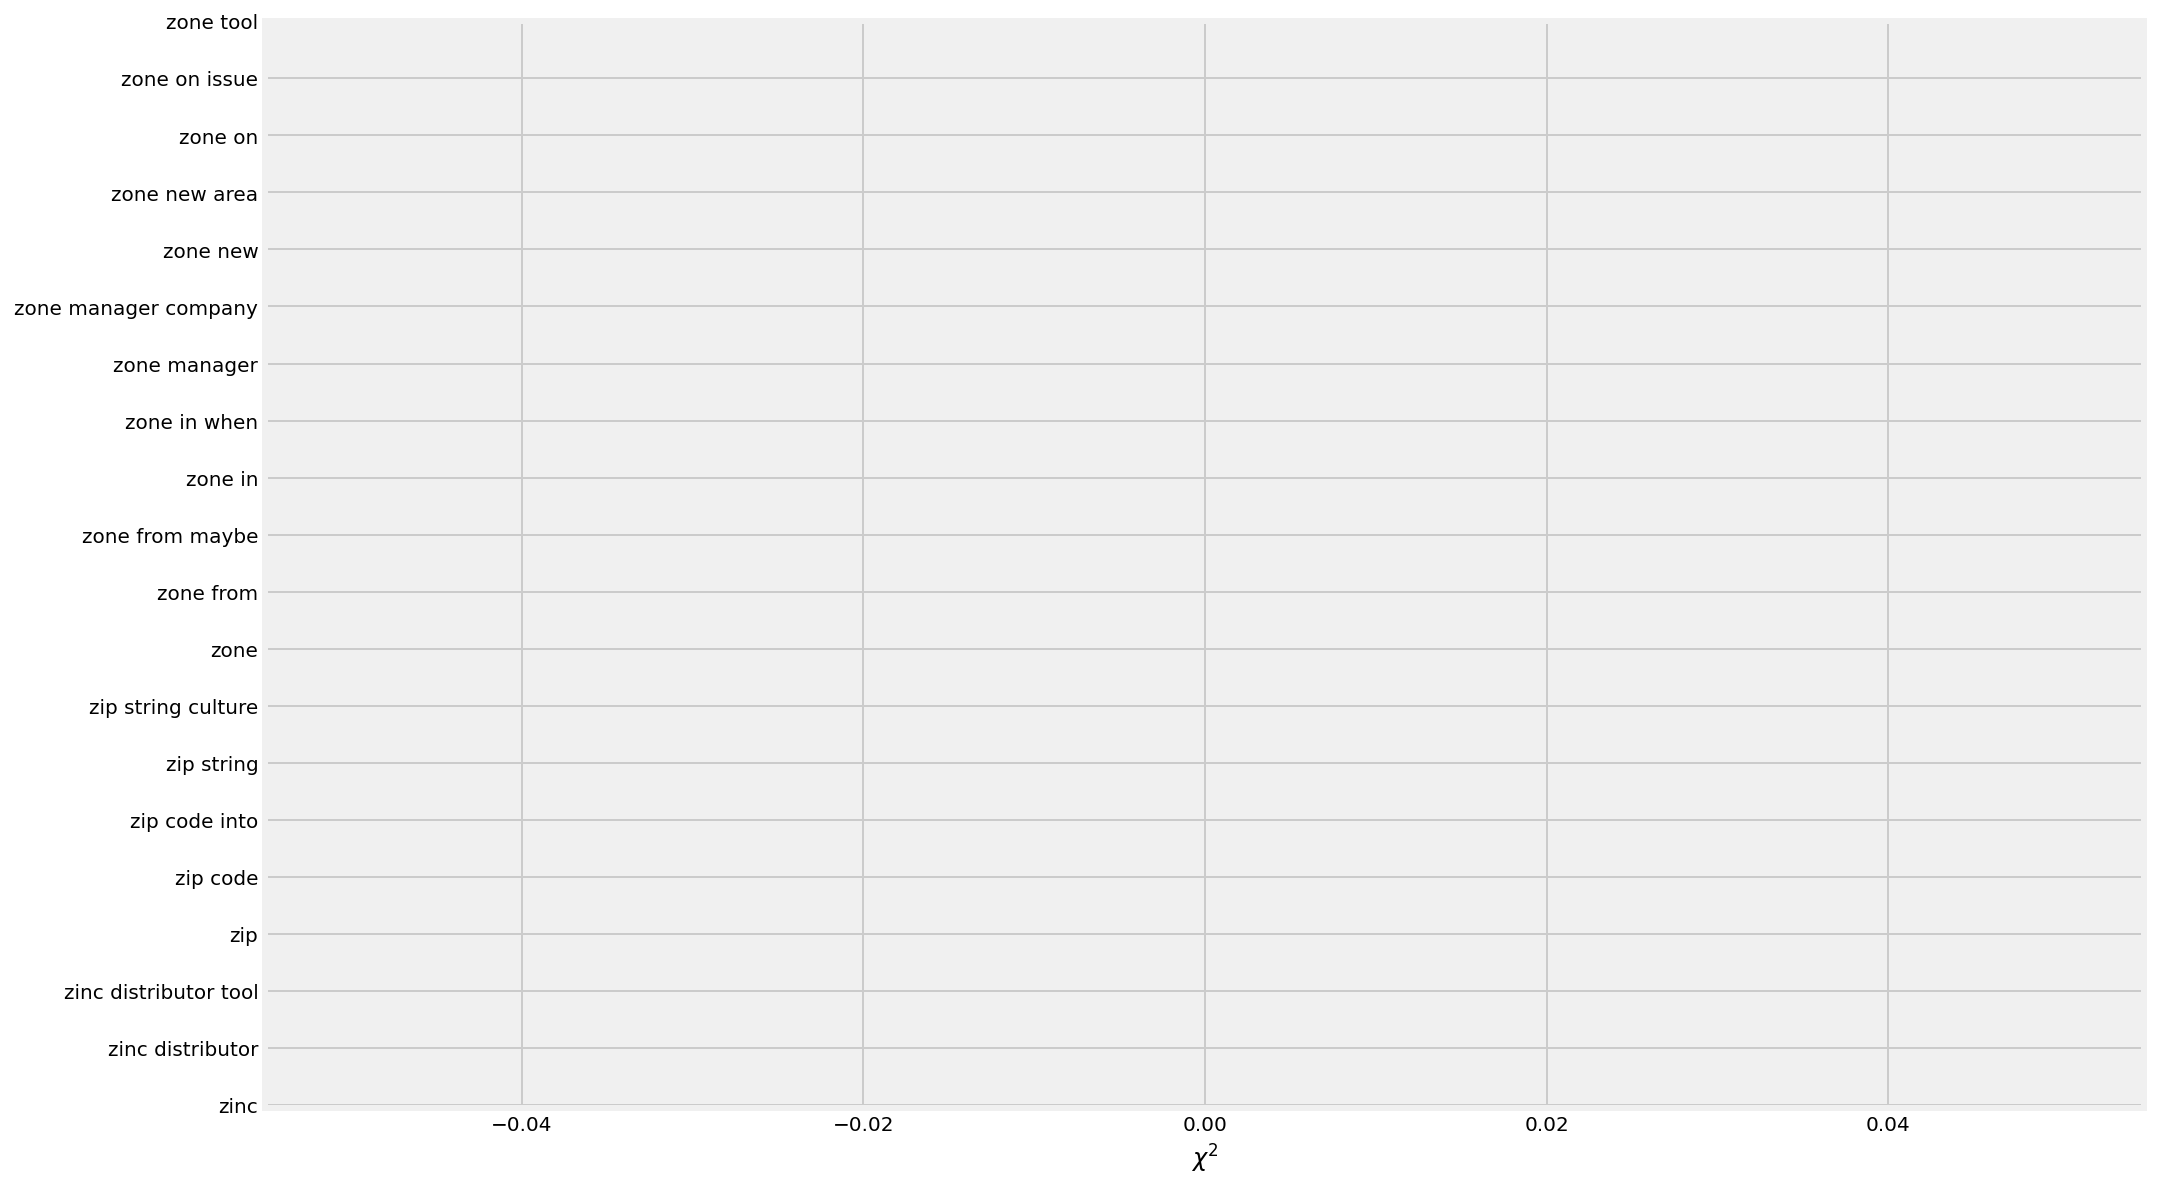

In [97]:
plt.figure(figsize=(15,10))
wscores = zip(tvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
#topchi2 = zip(wchi2)
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

### Principal Component Analysis (PCA)

In [98]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
d2v_ugdbow_tgdmm_std = scaler.fit_transform(train_vecs_ugdbow_tgdmm)
d2v_ugdbow_tgdmm_std_val = scaler.fit_transform(validation_vecs_ugdbow_tgdmm)

In [99]:
from sklearn.decomposition import PCA

d2v_pca = PCA().fit(d2v_ugdbow_tgdmm_std)

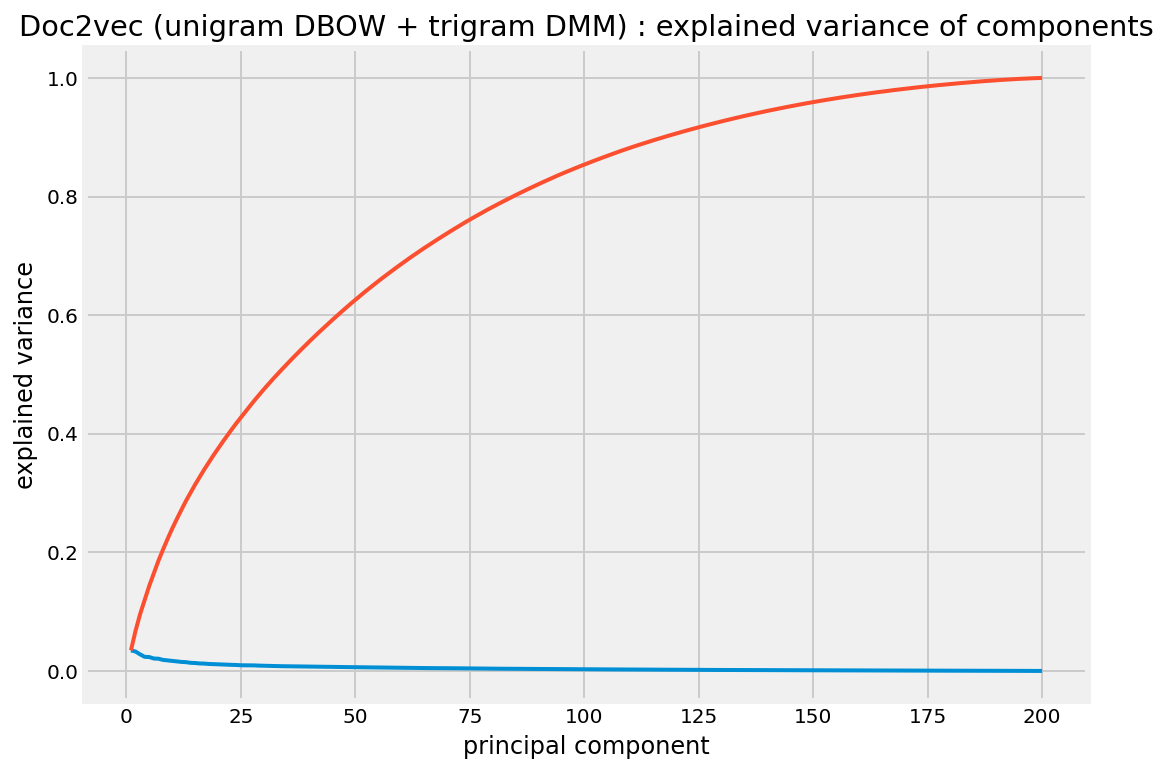

In [100]:
fig, ax = plt.subplots(figsize=(8,6))

x_values = range(1, d2v_pca.n_components_+1)

ax.plot(x_values, d2v_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(d2v_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('Doc2vec (unigram DBOW + trigram DMM) : explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

In [101]:
#while True:pass

In [102]:
from gensim.models import Doc2Vec

def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

In [103]:
model_ug_dbow = Doc2Vec.load('drive/MyDrive/grams/d2v_model_ug_dbow.doc2vec')
model_tg_dmm = Doc2Vec.load('drive/MyDrive/grams/d2v_model_tg_dmm.doc2vec')
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [104]:
train_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_train, 200)
validation_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_validation, 200)

In [105]:
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [106]:
x_train.shape[0]

6800

In [107]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [108]:
%%time
np.random.seed(seed)
model_d2v_01 = Sequential()
model_d2v_01.add(Dense(64, activation='relu', input_dim=200))
model_d2v_01.add(Dense(74, activation='sigmoid'))
model_d2v_01.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_d2v_01.fit(train_vecs_ugdbow_tgdmm, y_train, validation_data=(validation_vecs_ugdbow_tgdmm, y_validation), epochs=10, batch_size=32, verbose=2)

Epoch 1/10
213/213 - 2s - loss: 2.5396 - accuracy: 0.4957 - val_loss: 2.1569 - val_accuracy: 0.5106
Epoch 2/10
213/213 - 0s - loss: 1.8531 - accuracy: 0.5610 - val_loss: 1.9148 - val_accuracy: 0.5376
Epoch 3/10
213/213 - 0s - loss: 1.6182 - accuracy: 0.5913 - val_loss: 1.7914 - val_accuracy: 0.5518
Epoch 4/10
213/213 - 0s - loss: 1.4687 - accuracy: 0.6141 - val_loss: 1.7211 - val_accuracy: 0.5647
Epoch 5/10
213/213 - 0s - loss: 1.3603 - accuracy: 0.6346 - val_loss: 1.6867 - val_accuracy: 0.5765
Epoch 6/10
213/213 - 0s - loss: 1.2791 - accuracy: 0.6513 - val_loss: 1.6745 - val_accuracy: 0.5800
Epoch 7/10
213/213 - 0s - loss: 1.2121 - accuracy: 0.6700 - val_loss: 1.6594 - val_accuracy: 0.5776
Epoch 8/10
213/213 - 0s - loss: 1.1531 - accuracy: 0.6790 - val_loss: 1.6722 - val_accuracy: 0.5706
Epoch 9/10
213/213 - 1s - loss: 1.1064 - accuracy: 0.6874 - val_loss: 1.6714 - val_accuracy: 0.5788
Epoch 10/10
213/213 - 0s - loss: 1.0596 - accuracy: 0.7018 - val_loss: 1.6894 - val_accuracy: 0.5729

In [109]:
np.random.seed(seed)
model_d2v_02 = Sequential()
model_d2v_02.add(Dense(64, activation='relu', input_dim=200))
model_d2v_02.add(Dense(64, activation='relu'))
model_d2v_02.add(Dense(74, activation='softmax'))
model_d2v_02.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_d2v_02.fit(train_vecs_ugdbow_tgdmm, y_train, validation_data=(validation_vecs_ugdbow_tgdmm, y_validation), epochs=10, batch_size=32, verbose=2)

Epoch 1/10
213/213 - 1s - loss: 2.5128 - accuracy: 0.4928 - val_loss: 2.1150 - val_accuracy: 0.5071
Epoch 2/10
213/213 - 0s - loss: 1.7988 - accuracy: 0.5646 - val_loss: 1.8804 - val_accuracy: 0.5424
Epoch 3/10
213/213 - 0s - loss: 1.5750 - accuracy: 0.5975 - val_loss: 1.8013 - val_accuracy: 0.5553
Epoch 4/10
213/213 - 0s - loss: 1.4262 - accuracy: 0.6260 - val_loss: 1.7352 - val_accuracy: 0.5635
Epoch 5/10
213/213 - 0s - loss: 1.3160 - accuracy: 0.6522 - val_loss: 1.7003 - val_accuracy: 0.5753
Epoch 6/10
213/213 - 0s - loss: 1.2270 - accuracy: 0.6629 - val_loss: 1.7061 - val_accuracy: 0.5776
Epoch 7/10
213/213 - 0s - loss: 1.1526 - accuracy: 0.6782 - val_loss: 1.7038 - val_accuracy: 0.5753
Epoch 8/10
213/213 - 0s - loss: 1.0841 - accuracy: 0.6960 - val_loss: 1.7189 - val_accuracy: 0.5776
Epoch 9/10
213/213 - 0s - loss: 1.0197 - accuracy: 0.7106 - val_loss: 1.7501 - val_accuracy: 0.5753
Epoch 10/10
213/213 - 0s - loss: 0.9670 - accuracy: 0.7259 - val_loss: 1.7990 - val_accuracy: 0.5776

In [110]:
np.random.seed(seed)
model_d2v_03 = Sequential()
model_d2v_03.add(Dense(64, activation='relu', input_dim=200))
model_d2v_03.add(Dense(64, activation='relu'))
model_d2v_03.add(Dense(64, activation='relu'))
model_d2v_03.add(Dense(74, activation='softmax'))
model_d2v_03.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_d2v_03.fit(train_vecs_ugdbow_tgdmm, y_train, validation_data=(validation_vecs_ugdbow_tgdmm, y_validation), epochs=10, batch_size=32, verbose=2)

Epoch 1/10
213/213 - 1s - loss: 2.4909 - accuracy: 0.5013 - val_loss: 2.0941 - val_accuracy: 0.5153
Epoch 2/10
213/213 - 0s - loss: 1.8139 - accuracy: 0.5624 - val_loss: 1.8479 - val_accuracy: 0.5306
Epoch 3/10
213/213 - 0s - loss: 1.5928 - accuracy: 0.5928 - val_loss: 1.8105 - val_accuracy: 0.5553
Epoch 4/10
213/213 - 0s - loss: 1.4463 - accuracy: 0.6193 - val_loss: 1.7444 - val_accuracy: 0.5635
Epoch 5/10
213/213 - 0s - loss: 1.3390 - accuracy: 0.6419 - val_loss: 1.7173 - val_accuracy: 0.5612
Epoch 6/10
213/213 - 0s - loss: 1.2382 - accuracy: 0.6651 - val_loss: 1.7147 - val_accuracy: 0.5741
Epoch 7/10
213/213 - 0s - loss: 1.1551 - accuracy: 0.6800 - val_loss: 1.7320 - val_accuracy: 0.5824
Epoch 8/10
213/213 - 0s - loss: 1.0818 - accuracy: 0.6925 - val_loss: 1.7704 - val_accuracy: 0.5753
Epoch 9/10
213/213 - 0s - loss: 1.0132 - accuracy: 0.7122 - val_loss: 1.8163 - val_accuracy: 0.5671
Epoch 10/10
213/213 - 0s - loss: 0.9514 - accuracy: 0.7260 - val_loss: 1.8422 - val_accuracy: 0.5788

In [111]:
np.random.seed(seed)
model_d2v_04 = Sequential()
model_d2v_04.add(Dense(128, activation='relu', input_dim=200))
model_d2v_04.add(Dense(74, activation='softmax'))
model_d2v_04.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_d2v_04.fit(train_vecs_ugdbow_tgdmm, y_train, validation_data=(validation_vecs_ugdbow_tgdmm, y_validation), epochs=10, batch_size=32, verbose=2)

Epoch 1/10
213/213 - 1s - loss: 2.3729 - accuracy: 0.5084 - val_loss: 1.9739 - val_accuracy: 0.5353
Epoch 2/10
213/213 - 0s - loss: 1.6707 - accuracy: 0.5816 - val_loss: 1.7490 - val_accuracy: 0.5565
Epoch 3/10
213/213 - 0s - loss: 1.4264 - accuracy: 0.6253 - val_loss: 1.6596 - val_accuracy: 0.5871
Epoch 4/10
213/213 - 0s - loss: 1.2783 - accuracy: 0.6547 - val_loss: 1.6504 - val_accuracy: 0.5812
Epoch 5/10
213/213 - 0s - loss: 1.1685 - accuracy: 0.6749 - val_loss: 1.6511 - val_accuracy: 0.5882
Epoch 6/10
213/213 - 0s - loss: 1.0730 - accuracy: 0.7019 - val_loss: 1.6409 - val_accuracy: 0.5800
Epoch 7/10
213/213 - 0s - loss: 0.9990 - accuracy: 0.7197 - val_loss: 1.6788 - val_accuracy: 0.5976
Epoch 8/10
213/213 - 0s - loss: 0.9336 - accuracy: 0.7382 - val_loss: 1.6729 - val_accuracy: 0.6000
Epoch 9/10
213/213 - 0s - loss: 0.8739 - accuracy: 0.7562 - val_loss: 1.6842 - val_accuracy: 0.6082
Epoch 10/10
213/213 - 0s - loss: 0.8211 - accuracy: 0.7687 - val_loss: 1.7129 - val_accuracy: 0.5965

In [112]:
np.random.seed(seed)
model_d2v_05 = Sequential()
model_d2v_05.add(Dense(128, activation='relu', input_dim=200))
model_d2v_05.add(Dense(128, activation='relu'))
model_d2v_05.add(Dense(74, activation='softmax'))
model_d2v_05.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_d2v_05.fit(train_vecs_ugdbow_tgdmm, y_train, validation_data=(validation_vecs_ugdbow_tgdmm, y_validation), epochs=10, batch_size=32, verbose=2)

Epoch 1/10
213/213 - 1s - loss: 2.3210 - accuracy: 0.5141 - val_loss: 1.9783 - val_accuracy: 0.5376
Epoch 2/10
213/213 - 0s - loss: 1.6492 - accuracy: 0.5865 - val_loss: 1.7477 - val_accuracy: 0.5647
Epoch 3/10
213/213 - 0s - loss: 1.3932 - accuracy: 0.6310 - val_loss: 1.6514 - val_accuracy: 0.5776
Epoch 4/10
213/213 - 0s - loss: 1.2264 - accuracy: 0.6685 - val_loss: 1.6283 - val_accuracy: 0.5871
Epoch 5/10
213/213 - 0s - loss: 1.0852 - accuracy: 0.7003 - val_loss: 1.6533 - val_accuracy: 0.5929
Epoch 6/10
213/213 - 0s - loss: 0.9729 - accuracy: 0.7262 - val_loss: 1.6361 - val_accuracy: 0.5882
Epoch 7/10
213/213 - 0s - loss: 0.8730 - accuracy: 0.7544 - val_loss: 1.6806 - val_accuracy: 0.5953
Epoch 8/10
213/213 - 0s - loss: 0.7862 - accuracy: 0.7760 - val_loss: 1.7994 - val_accuracy: 0.5894
Epoch 9/10
213/213 - 0s - loss: 0.7178 - accuracy: 0.7966 - val_loss: 1.8150 - val_accuracy: 0.5718
Epoch 10/10
213/213 - 0s - loss: 0.6449 - accuracy: 0.8169 - val_loss: 1.8485 - val_accuracy: 0.5753

In [113]:
np.random.seed(seed)
model_d2v_06 = Sequential()
model_d2v_06.add(Dense(128, activation='relu', input_dim=200))
model_d2v_06.add(Dense(128, activation='relu'))
model_d2v_06.add(Dense(128, activation='relu'))
model_d2v_06.add(Dense(74, activation='softmax'))
model_d2v_06.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_d2v_06.fit(train_vecs_ugdbow_tgdmm, y_train, validation_data=(validation_vecs_ugdbow_tgdmm, y_validation), epochs=10, batch_size=32, verbose=2)

Epoch 1/10
213/213 - 1s - loss: 2.2847 - accuracy: 0.5181 - val_loss: 1.9581 - val_accuracy: 0.5294
Epoch 2/10
213/213 - 0s - loss: 1.6618 - accuracy: 0.5865 - val_loss: 1.7706 - val_accuracy: 0.5694
Epoch 3/10
213/213 - 0s - loss: 1.4332 - accuracy: 0.6253 - val_loss: 1.7038 - val_accuracy: 0.5847
Epoch 4/10
213/213 - 0s - loss: 1.2591 - accuracy: 0.6572 - val_loss: 1.6861 - val_accuracy: 0.5776
Epoch 5/10
213/213 - 0s - loss: 1.1197 - accuracy: 0.6875 - val_loss: 1.7197 - val_accuracy: 0.5694
Epoch 6/10
213/213 - 0s - loss: 0.9869 - accuracy: 0.7174 - val_loss: 1.7192 - val_accuracy: 0.5718
Epoch 7/10
213/213 - 0s - loss: 0.8727 - accuracy: 0.7465 - val_loss: 1.8152 - val_accuracy: 0.5718
Epoch 8/10
213/213 - 0s - loss: 0.7683 - accuracy: 0.7784 - val_loss: 1.8776 - val_accuracy: 0.5624
Epoch 9/10
213/213 - 0s - loss: 0.6742 - accuracy: 0.8088 - val_loss: 1.9458 - val_accuracy: 0.5682
Epoch 10/10
213/213 - 0s - loss: 0.5922 - accuracy: 0.8306 - val_loss: 2.2105 - val_accuracy: 0.5659

In [115]:
#while True:pass